In [1]:
import numpy as np
from numpy import matlib
import scipy.stats

import numba
import tqdm
# from t
import multiprocess
import scipy
from scipy.fft import ifft, ifft2, ifftn, irfft, irfftn


import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import sklearn 
from sklearn.linear_model import LinearRegression

import time
t1 = time.time()

In [2]:
# %load_ext line_profiler


# a e s t h e t i c s

In [3]:
model_colors = ['mediumpurple','mediumaquamarine','orchid']
model_names = ('PFR fit','CSTR fit','LFR fit')

fs = 18
lw=4
dims = (8,5)

## Simulation


In [4]:
# @numba.njit
def step(calc_flux, population, t, *args):
    '''
    Takes flux calculating function, past event, 
    flux, population, t, args and
    returns time to reaction and the reaction that happens
    '''
    flux = calc_flux( population, *args)[0]
    flux_sum = np.sum(flux)
    t = np.random.exponential(1. / flux_sum)
    rxn_prob = flux/flux_sum
    rxn = sample_rxns(rxn_prob)
    return rxn, t

def sample_rxns(prob_arr):
    '''
    Takes prob_arr and
    returns an randomly sampled index according to 
    the probabilities specificed in prob_arr
    '''
    num = np.random.rand()
    sent = 0
    tot = 0.
    while tot < num:
        tot = tot + prob_arr[sent]
        sent = sent + 1
    return sent - 1


In [5]:
# @numba.njit
def step_with_queued(calc_flux,population,t,queued_reactions,queued_reaction_times,export_arr,*args):
    '''
    Takes flux calculating function, past event, 
    flux, population, t, args and
    returns time to reaction and the reaction that happens
    '''

    if len(queued_reactions)==0:
        return step(calc_flux,population,t,*args)
    else:
        # 
        population = np.copy(population)
        population_orig = np.copy(population)
        queued_reaction_times = np.copy(queued_reaction_times)

        init_flux = calc_flux( population, *args)[0]
        n_rxn = len(init_flux)
        fluxes = np.zeros((len(queued_reactions)+1,n_rxn))
        fluxes[0] = calc_flux( population, *args)[0]
        for q in range(len(queued_reactions)):
            population += export_arr[queued_reactions[q]]
            fluxes[q+1] = calc_flux( population, *args)[0]

        queued_reaction_times = np.concatenate(([t],queued_reaction_times))
        flux_sums = fluxes[:-1] * np.diff(queued_reaction_times)[:,None]
        flux_sums = np.concatenate((np.zeros(n_rxn)[None,:],flux_sums))
        flux_cumsums = np.cumsum(flux_sums,0)
        tot_flux_cumsum = flux_cumsums.sum(1)

        u = np.random.rand()
        flux = np.log(1/u)
        
        last_ind = np.where(tot_flux_cumsum<flux)[0][-1]
        dt = queued_reaction_times[last_ind]-t
        flux_orig = np.copy(flux)
        flux -= tot_flux_cumsum[last_ind]
        dtprime = flux/fluxes[last_ind].sum()
        dt += dtprime

        flux_sum = fluxes[last_ind]
        rxn_prob = flux_sum / flux_sum.sum()
        rxn = sample_rxns(rxn_prob)   
        return rxn, dt
# def markovian_simulate(calc_flux, update, population_0, t_arr, tau, \
#                        DELAYED_SPECIES_GENERATORS, export_arr,burst_events, tau_list=None,\
#                        return_full=False,*args):

def markovian_simulate(calc_flux, update, population_0, t_arr, tau, \
                       DELAYED_SPECIES_GENERATORS, export_arr,burst_events, burst_size_time_dep, tau_list=None,\
                       return_full=False,*args):
    '''
    Takes params and
    returns matrix of the number of counts for 
    a species j at time t[i]
    '''
    if isinstance(tau , list) or isinstance(tau , tuple) :
        n_delays = len(tau)
    else:
        tau = [tau]
        n_delays = 1
        
    niter = 0

    population_arr = np.zeros((len(t_arr), update.shape[1]))
    t = t_arr[0]
    population = population_0.copy()
    population_arr[0, :] = population
    t_list = []
    population_list = []
    rxn_list = []

    t_list.append(t)
    population_list.append(population)
    
#     print(burst_events)
#     print(update)
#     raise ValueError

    # Delay time queue
    if tau_list is None:
        tau_list = [[]]*n_delays
    tau_list_delay_inds = np.asarray(sum([[j]*len(x) for j,x in enumerate(tau_list)],[]))
    tau_list_all_delays = np.concatenate(tau_list)
    tau_list_sort = np.argsort(tau_list_all_delays).astype(int)

    tau_list_delay_inds = list(tau_list_delay_inds[tau_list_sort])
    tau_list_all_delays = list(tau_list_all_delays[tau_list_sort])
    
    while t < t_arr[-1]:
        event,dt = step_with_queued(calc_flux,population,t,\
                                    tau_list_delay_inds,tau_list_all_delays,\
                                    export_arr, *args)
        

        temp_t = t + dt
        
        # Check if an export event should slot in before t + dt
        while (len(tau_list_all_delays) != 0) and (temp_t > tau_list_all_delays[0]):
            population = population + export_arr[tau_list_delay_inds[0]]
            t = tau_list_all_delays[0]
            if t>t_arr[-1]:
                break
            t_list.append(t)
            population_list.append(population)
            rxn_list.append(-tau_list_delay_inds[0]-1)
            tau_list_all_delays.pop(0) # remove element
            tau_list_delay_inds.pop(0)

        if len(tau_list_all_delays)!=len(tau_list_delay_inds):
            raise ValueError
        
        # Perform event
        t = temp_t
        if event in burst_events:
            UPD = np.copy(update[event,:])
            bs_instantaneous = burst_size_time_dep(t)
            UPD[UPD>0] = np.random.geometric(1/(1+bs_instantaneous))-1
        else:
            UPD = update[event, :]
        population = population + UPD
        t_list.append(t)
        population_list.append(population)
        rxn_list.append(event)


        for j in range(n_delays):
            if event in DELAYED_SPECIES_GENERATORS[j]:
                tau_list_all_delays.append(t + tau[j])
                tau_list_delay_inds.append(j)
        tau_list_sort = np.argsort(tau_list_all_delays).astype(int)
        tau_list_delay_inds = list(np.asarray(tau_list_delay_inds)[tau_list_sort])
        tau_list_all_delays = list(np.asarray(tau_list_all_delays)[tau_list_sort])
    
    t_only_arr = np.asarray(t_list)
    population_list= np.asarray(population_list)
    for i in range(len(t_only_arr)):
        # print(t_only_arr)
        ind = np.searchsorted(t_arr, t_only_arr[i], side = 'right')
        # print(ind)
        population_arr[ind:] = np.array(population_list[i])
    if return_full:
        return population_arr,t_only_arr,population_list,rxn_list
    else:
        return population_arr


In [6]:
def nondelay_wrapper(N,n,K_val,A_val,burst_size_time_dep,beta_val,gamma_val,initcond,number_of_cells=5000,simulation_time=5,ndel=50,t_arr=None,disable_tqdm=True):
# def nondelay_wrapper(N,n,K_val,A_val,b_val,beta_val,gamma_val,initcond,number_of_cells=5000,simulation_time=5,ndel=50):
#     print(beta_val)
    H,A,C,S,k,Hss,burst_events = sim_setup(N,n,K_val,A_val,beta_val,gamma_val)
#     H,A,C,S,k,Hss,burst_events = sim_setup(N,n,K_val,A_val,b_val,beta_val,gamma_val)
# 
    delayed_species = []
    DELAYED_SPECIES_GENERATORS = [[]]

    tau = []

    ####
    update_arr = S

#     print(S)
#     print(H)
#     print(A)
#     print(C)
#     print(k)
#     print(Hss)
#     print(burst_events)
    
    if t_arr is None:
        t_arr = np.linspace(0, simulation_time, ndel,endpoint=False)


    export_arr = np.zeros((len(delayed_species),N+n),dtype=int)


    samples = np.zeros((number_of_cells, len(t_arr), N+n))


    Hss = scipy.linalg.null_space(H.T)
    Hss /= Hss.sum()
    Hss = Hss.squeeze()

    for i in tqdm.tqdm(range(number_of_cells),disable=disable_tqdm):
        population_0 = np.zeros(N+n,dtype=int)
        if initcond[0][0]=='thermalized':
            init_state_prob = Hss
        elif isinstance(initcond[0][1],int):
            init_state_prob = np.zeros(N)
            jinit = initcond[0][1]
            init_state_prob[jinit] = 1
        else:
            init_state_prob = initcond[0][1]
        if N>1:
            population_0[:N] = np.random.multinomial(1,init_state_prob,1)
        else:
            population_0[:N] = 1
        initial_promoter_state = np.where(population_0[:N]==1)[0][0]

        for j,condition in enumerate(initcond[1:]):
            if isinstance(condition[0],str):
                if condition[0]=='deterministic':
                    population_0[j+N] = condition[1]
                elif condition[0]=='poisson':
                    population_0[j+N] = np.random.poisson(condition[1])
            else:
                if condition[initial_promoter_state][0]=='deterministic':
                    population_0[j+N] = condition[initial_promoter_state][1]
                elif condition[initial_promoter_state][0]=='poisson':
                    population_0[j+N] = np.random.poisson(condition[initial_promoter_state][1])
        samples[i, :, :],event_t,event_x,_ = markovian_simulate(
            propfun_generic, update_arr, population_0, t_arr, \
            tau, DELAYED_SPECIES_GENERATORS, export_arr,burst_events,burst_size_time_dep,[[]],\
            True,(k,K_val,A_val,beta_val,gamma_val,N))
    return t_arr,samples,H,A,C,init_state_prob,burst_events


## Bursty model solution

In [7]:
def sim_setup(N,n,K_val,A_val,beta_val,gamma_val):

    H = np.zeros((N,N))
    for kv in K_val:
        H[kv[0],kv[1]] = kv[2]
    H -= np.diag(H.sum(1))

    A = np.zeros((N,n))
    for av in A_val:
        A[av[0],av[1]-1] = av[2]

    B = np.zeros((n,n))
#     print(beta_val)
    for bv in beta_val:
        B[bv[0]-1,bv[1]-1] = bv[2]
    B -= np.diag(B.sum(1))
    for gv in gamma_val:
        B[gv[0]-1,gv[0]-1] -= gv[1]
    

    Nspec = N+n
    Nrxn = len(K_val) + len(A_val) + len(gamma_val) + len(beta_val)
    S_mark = np.zeros((Nrxn,Nspec))
    k_mark = np.zeros(Nrxn)

    i=0
    burst_events = []
    for kv in K_val:
        S_mark[i,kv[0]] = -1
        S_mark[i,kv[1]] = 1
        k_mark[i] = kv[2]
        i+=1

    
#     for av,bv_ in zip(A_val,b_val):
#         if bv_ > 0:
#             burst_events += [i]
#             S_mark[i,av[1]+N-1] = bv_
#         else:
#             S_mark[i,av[1]+N-1] = 1
#         k_mark[i] = av[2]
#         i+=1

    for av in A_val:
        #note we assume there is just the one burst event! 
        burst_events += [i]
        S_mark[i,av[1]+N-1] = 1
        k_mark[i] = av[2]
        i+=1
        
    for bv in beta_val:
        S_mark[i,bv[0]+N-1] = -1
        S_mark[i,bv[1]+N-1] = 1
        k_mark[i] = bv[2]
        i+=1
        
    for gv in gamma_val:
        S_mark[i,gv[0]+N-1] = -1    
        k_mark[i] = gv[1]
        i+=1

    Hss = scipy.linalg.null_space(H.T)
    Hss /= Hss.sum()
    Hss = Hss.squeeze()

    S_mark = S_mark.astype(int)

    return H,A,B,S_mark,k_mark,Hss,burst_events
    # print(B)

def propfun_generic(x,*args):
    # print(args)
    k,K_val,A_val,beta_val,gamma_val,N = args[0]
    nRxn = len(k)
    nCells = x.shape[0]

    a = np.zeros((nCells,nRxn),dtype=float)
    x = x.T
    a = a.T
    #######
    j = 0 
    for i in range(len(K_val)):
        a[j] = k[j] * x[K_val[i][0]]
        j+=1
    for i in range(len(A_val)):
        a[j] = k[j] * x[A_val[i][0]]
        j+=1
    for i in range(len(beta_val)):
        a[j] = k[j] * x[beta_val[i][0]+N-1]
        j+=1
    for i in range(len(gamma_val)):
        a[j] = k[j] * x[gamma_val[i][0]+N-1]
        j+=1
    # print(a)
    # print(x)
    # raise ValueError
    return a.T


In [8]:
def get_g(limits):
    u = []
    mx = np.copy(limits)
    mx[-1] = mx[-1] // 2 + 1

    for i in range(len(mx)):
        l = np.arange(mx[i])
        u_ = np.exp(-2j*np.pi*l/limits[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    return g,mx


def ufun_mat(g,x,beta,gamma):
    U =  np.exp(-gamma * x) * g[1]
    return U

def ufun_generic(g,x,beta,gamma):
#     print()
    if np.isclose(beta, gamma):  # compute prefactors for the ODE characteristics.
        c_1 = g[0]  # nascent
        c_2 = x * beta * g[1]
    else:
        f = beta / (beta - gamma)
        c_2 = g[1] * f
        c_1 = g[0] - c_2
    U = (np.exp(-beta * x) * c_1 + np.exp(-gamma * x) * c_2)
    return U

In [9]:
def pss_wrapper(k,beta,gamma,burst_size_time_dep,t,mx,initcond):
    N=1
    n=2
    try:
        nT = len(t)
    except:
        nT = 1
        t = [t]
        
    g,mx_red = get_g(mx)
    g = np.asarray(g).T
    gf_initcond_prop = np.ones((g.shape[0],nT),dtype=np.complex128)

    ufuncs = [ufun_generic,ufun_mat]
    for j,condition in enumerate(initcond):
        if isinstance(condition[0],str): #Identical conditions for all states
            if condition[0]=='deterministic':
                initcond_gfun = lambda x: (x+1)**condition[1]
            elif condition[0]=='poisson':
                initcond_gfun = lambda x: np.exp(condition[1]*x)
            if condition[1]>0:
                for i in range(g.shape[0]):
                    gf_initcond_prop[i,:] *= initcond_gfun(ufuncs[j](g[i],t,beta,gamma)) #slow slow slow!
        else: 
            print(N)
            print(len(condition[0]))
            raise ValueError
    gf = gfun_numerical(g,t,k,beta,gamma,burst_size_time_dep)
    gf *= (gf_initcond_prop)
    gf = np.reshape(gf,np.concatenate((mx_red,[nT])).astype(int))
    Pss = irfftn(gf,axes=[0,1],s=mx)
#     Pss = Pss.squeeze()
    return Pss


In [39]:

def gfun_numerical(g,t,k,beta,gamma,burst_size_time_dep):
    N=1
    nT = len(t)
    gf_ = np.zeros((g.shape[0],nT),dtype=np.complex128)
    bvec = np.asarray([burst_size_time_dep(t_) for t_ in t])
    if not np.isclose(beta,gamma):
        f = beta/(beta-gamma)
        Uv = [np.exp(-beta * t), np.exp(-gamma * t)]
        Uv = [Uv[0],f*(Uv[1]-Uv[0])]
    else:
        Uv = np.exp(-beta * t)
        Uv = [Uv,t*Uv]
    
    
    for i in (range(g.shape[0])):
        t0 = 0
        y0 = np.zeros((N),dtype=np.complex128)
        Uvec = Uv[0]*g[i][0] + Uv[1]*g[i][1] #highly optimized: all characteristics are precomputed
        integ = intfun_trapz(t,Uvec,k,bvec)
        gf_[i,:] = integ
    return np.exp(gf_)

def intfun_trapz(tvec,Uvec,k,bvec):
    nT = len(tvec)
    bUmat = scipy.linalg.toeplitz(bvec,np.asarray([bvec[0]]+(nT-1)*[ 0]))
    bUmat=np.multiply(bUmat,Uvec)
    """
    This is heavily optimized. Toeplitz is fast. I've tried iterating over t,
    building numpy and scipy.sparse diag matrices, and a couple of other ideas.
    """
    
    bUmat = 1/(1-bUmat)-1
    
    integ = np.trapz(bUmat,tvec,axis=1)
    return k*integ


In [11]:
conditional_colors = ('red','cadetblue','deeppink','khaki')
uncond_colors = ('lightgray','darkgray')
alf=0.5
def viz_nondelay(t_arr,samples,k,beta,gamma,burst_size_time_dep,initcond,t_pts = [0,2,5,10,49]):
    nt=len(t_pts)
    n=2
    N=1
    fig1,ax1=plt.subplots(nt,n,figsize=(8,12))
    
    
    Pss_all = []
    t1 = time.time()
#     mx = [64,32]
    mx = [int(samples[:,:,N+i].max()+4) for i in range(n)]
    Pss_joint = pss_wrapper(k,beta,gamma,burst_size_time_dep,t_arr,mx,initcond)[:,:,t_pts]
    Pss_all=[Pss_joint.sum(1-i) for i in range(n)]
    t2 = time.time()
    print('Runetime: {:.2f} seconds.'.format(t2-t1))
    
    for k,tind in enumerate(t_pts):
        t=t_arr[tind]

        X=samples[:,tind,:]

        ax1[k,0].set_ylabel('t = {:.2f}'.format(t))
        for i in range(n):
            mx = [1]*n

            ub = X[:,N+i].max() + 2
            mx[i] = int(ub)
            Pss = Pss_all[i][:,k]

            bins = np.arange(X[:,N+i].max()+6)-0.5
            hist,_ = np.histogram(X[:,N+i],bins,density=True)
            ax1[k,i].bar(bins[:-1]+0.5,hist,color=uncond_colors[0],alpha=alf)

            ax1[k,i].plot(Pss,color=uncond_colors[1])


            ax1[k,i].set_xticks([])
            ax1[k,i].set_yticks([])
    fig1.tight_layout()


## Inference functions

In [12]:
def optimize_logL_reactor(X,tvec,true_pars,switch_times,maxiter=20,disp=False):
    n = 2
    mx = [int(X[:,:,i].max()+5) for i in range(n)]
    
#     true_pars = np.log10(burst_size_values+[k,beta,gamma])
    npar = 6
    lb = np.asarray([-1.5]*npar)
    ub = np.asarray([1.5]*npar)
    bnd = scipy.optimize.Bounds(lb,ub)
    x0 = np.random.rand(npar)*(ub-lb)+lb
    onedimobj = lambda x:  objfun(x,X,tvec,mx,switch_times)
#     print('Obj func value at true parameters: {:.2f}.'.format(onedimobj(true_pars)))
#     print('Starting obj func value: {:.2f}.'.format(onedimobj(x0)))
    x0 = true_pars
    res_arr = scipy.optimize.minimize(fun=onedimobj,x0=x0,bounds=bnd,method='L-BFGS-B',options={'maxiter':maxiter,'disp':disp})
#     print('Obj func value at end of search: {:.2f}.'.format(res_arr.fun))
    return res_arr

def objfun(log_pars,X,tvec,mx,switch_times):
    EPS = 1e-12
    n_cells = len(tvec) #obviously change this if using a different grid
    b1,b2,b3,k_,beta_,gamma_ = 10**log_pars
    bs_vals = [b1,b2,b3]
    muN0 = b1*k_/beta_
    muM0 = b1*k_/gamma_

    initcond = [['poisson',muN0],
                ['poisson',muM0]]

    burst_size_time_dep_test = lambda t: burst_size_time_dep_fun(t,switch_times,bs_vals)
    Pss_joint = pss_wrapper(k_,beta_,gamma_,burst_size_time_dep_test,tvec,mx,initcond)
    Pss_joint[Pss_joint<EPS]=EPS
    nLL = negLogL(X,Pss_joint,n_cells)
    return nLL
    
def negLogL(X,Pss_joint,n_cells):
    lik_tot = 0
    for t_ in range(n_cells):
        try:
            lik_tot -= np.log(Pss_joint[X[t_,t_,0],X[t_,t_,1],t_])
        except:
            print(lik_tot)
            print(Pss_joint[X[t_,t_,0],X[t_,t_,1],t_])
            raise ValueError
    return lik_tot

## Parallelization

In [13]:

def parallelize(
    function,
    iterable,
    num_cores,
    num_entries,
    completion_message="Parallelization complete.",
    termination_message="Parallelization manually terminated.",
    error_message="Parallelization terminated due to error.",
    use_tqdm=True,
):
    """Helper function to safely parallelize computations.
    Recycled from Monod.
    """
#     print(function)
#     raise ValueError
    
    
    try:
        pool = multiprocess.Pool(processes=num_cores)
        if use_tqdm:
            x = list(tqdm.tqdm(pool.imap(function, iterable), total=num_entries))  # hacky
        else:
            x = pool.map(function, iterable)
        pool.close()
        pool.join()
        print(completion_message)
    except KeyboardInterrupt:
        print(termination_message)
        pool.terminate()
        pool.join()
    except ValueError:
        print(error_message)
        pool.terminate()
        pool.join()
    return x


def parallelized_trial(n_cells,norm_std,norm_mean,T,switch_times,max_state_space_size,seed=2813308004,return_data=False):
    
    np.random.seed(seed)
#     T = 5
    uni_reactor = scipy.stats.uniform(0,T)
    t_true_sim = np.sort(uni_reactor.rvs(n_cells))

    N = 1
    n = 2
    K_val = []

    max_val = np.inf
    while max_val>max_state_space_size:
        rands = 10**(np.clip(np.random.randn(6)*norm_std+norm_mean,-1.4,1.4))
        burst_size_values = list(rands[:3])
        k, beta, gamma = rands[3:]
        max_B = np.max(burst_size_values)
        max_mean = max_B*k*np.asarray([1/beta,1/gamma])
        max_std = np.sqrt(max_mean*(1+ max_B*np.asarray([1,beta/(beta+gamma)])))
        max_domain = max_mean + 4*max_std
        max_val = max_domain.max()
#         print(max_domain)
#     pars_cells.append(rands)
    pars = np.copy(rands)
#     print(pars)
#     pri
    
#     raise ValueError
#     print(max_val)

    
    A_val =[[0,1,k]]
    beta_val = [[1,2,beta]]
    gamma_val = [[2,gamma]]
    burst_size_time_dep = lambda t: burst_size_time_dep_fun(t,switch_times,burst_size_values)
    muN0 = burst_size_values[0]*k/beta
    muM0 = burst_size_values[0]*k/gamma

    initcond = [['thermalized'],
                ['poisson',muN0],
                ['poisson',muM0]]
    t_arr,samples,H,A,C,init_state_prob,burst_events = nondelay_wrapper(N,n,K_val,A_val,burst_size_time_dep,beta_val,gamma_val,
                                                                        initcond,
                                                                        simulation_time=T,number_of_cells=n_cells,
                                                                        t_arr = t_true_sim,disable_tqdm=True)
    X = samples[:,:,1:].astype(int)

    fracs_in_ct = np.asarray([switch_times[1]-switch_times[0],switch_times[2]-switch_times[1],0]).astype(float)
    fracs_in_ct /= T
    fracs_in_ct[-1] = 1-fracs_in_ct.sum()

    #############################3
    uniform_orderstat_mean = t_true_sim/T
    t_uni = uni_reactor.ppf(uniform_orderstat_mean)
    switch_times_uni = uni_reactor.ppf(np.cumsum([0]+list(fracs_in_ct[:-1])))

    res_arr_uni=optimize_logL_reactor(X,t_uni,np.log10(pars),switch_times_uni)

    t_exp = cstr_ppf(uniform_orderstat_mean,T)
    switch_times_exp = cstr_ppf(np.cumsum([0]+list(fracs_in_ct[:-1])),T)

    res_arr_exp=optimize_logL_reactor(X,t_exp,np.log10(pars),switch_times_exp)

    t_lfr = lfr_ppf(uniform_orderstat_mean,T)
    switch_times_lfr = lfr_ppf(np.cumsum([0]+list(fracs_in_ct[:-1])),T)

    res_arr_lfr=optimize_logL_reactor(X,t_lfr,np.log10(pars),switch_times_lfr)

    res_models = [res_arr_uni,res_arr_exp,res_arr_lfr]
#     print('{:.2f}\t{:.2f}\t{:.2f}'.format(res_arr_uni.fun,res_arr_exp.fun,res_arr_lfr.fun))
    
    result_ = (pars,res_models)
    if return_data:
        return (result_,X,samples,initcond,
                t_true_sim,(t_uni,switch_times_uni),(t_exp,switch_times_exp),(t_lfr,switch_times_lfr))
    else:
        return result_


## Piecewise constant burst size time dependence

In [14]:
def burst_size_time_dep_fun(t,switch_times,burst_size_values):
    for st,bv in zip(reversed(switch_times),reversed(burst_size_values)):
        if t >= st:
            return bv
    return 0
    

## Reactor quantile functions

In [15]:
def cstr_ppf(x,T):
    t = np.ones_like(x)
    for k in range(len(t)):
        if k==0:
            x0 = 0.0
        else:
            x0 = t[k-1]
        t[k] = scipy.optimize.minimize(lambda t_: (x[k]-(t_*scipy.special.exp1(t_)+1 -np.exp(-t_)))**2,x0=x0, 
                        bounds=scipy.optimize.Bounds(1e-12,np.inf)).x[0]
    t *= T
    return t

def lfr_ppf(x,T):
    t = np.ones_like(x)
    t[x<=2/3] = 3*T*x[x<=2/3]/4
    t[x>2/3] = T*np.sqrt(1/(12*(1-x[x>2/3])))
    return t

# Everything above this has to be run.

# Reactor configurations

In [41]:
nsim = 10000


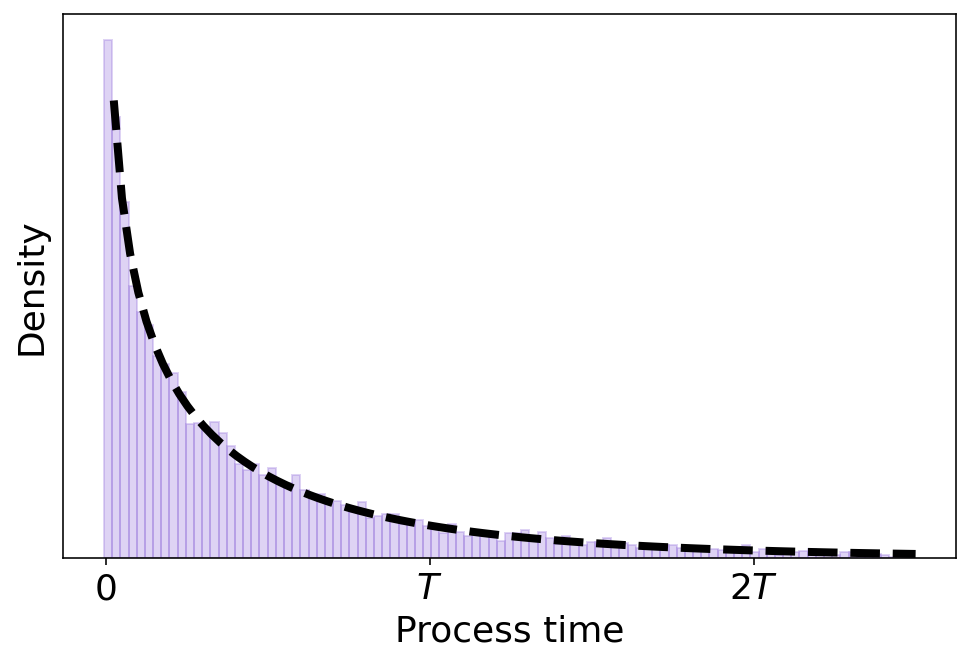

In [42]:
fig1,ax1 = plt.subplots(1,1,figsize=dims)

T = 2
t_ = np.linspace(0,5,100)

restime_exp = scipy.special.exp1(t_/T)/T
ax1.plot(t_,restime_exp,'k--',linewidth=lw)
restime_sim = scipy.stats.uniform(0,scipy.stats.expon(0,T).rvs(nsim)).rvs()
bins = t_-0.01

_=ax1.hist(restime_sim,bins,density=True,facecolor=model_colors[0],alpha=0.3,edgecolor=model_colors[0])
ax1.set_xlabel('Process time',fontsize=fs)
ax1.set_ylabel('Density',fontsize=fs)
ax1.set_yticks([])
ax1.set_xticks([0,T,2*T],['0',r'$T$',r'$2T$'],fontsize=fs)

plt.savefig('figs/cstr_iad.png',dpi=450)
plt.savefig('figs/cstr_iad.pdf')

In [43]:
# T

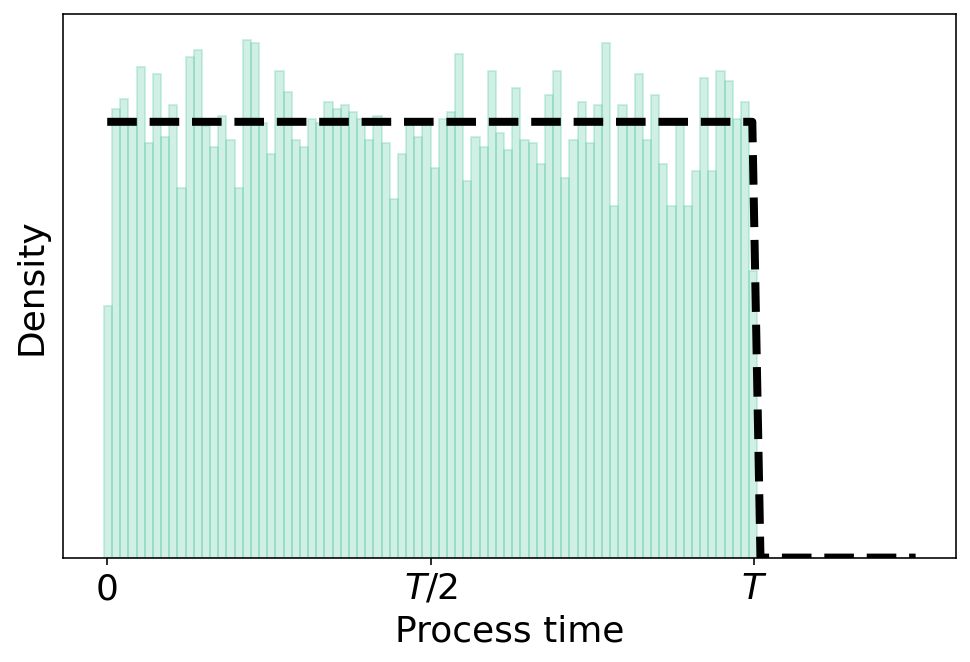

In [44]:
fig1,ax1 = plt.subplots(1,1,figsize=dims)

T = 2
t_ = np.linspace(0,2.5,100)
restime_uni = np.zeros_like(t_)
restime_uni[t_<= T] = 1/T
ax1.plot(t_,restime_uni,'k--',linewidth=lw)

restime_sim = (scipy.stats.uniform(0,T).rvs(nsim))
bins = t_-0.01

_=ax1.hist(restime_sim,bins,density=True,facecolor=model_colors[1],alpha=0.3,edgecolor=model_colors[1])
ax1.set_xlabel('Process time',fontsize=fs)
ax1.set_ylabel('Density',fontsize=fs)
ax1.set_yticks([])
ax1.set_xticks([0,T/2,T],['0',r'$T/2$',r'$T$'],fontsize=fs)

plt.savefig('figs/pfr_iad.png',dpi=450)
plt.savefig('figs/pfr_iad.pdf')


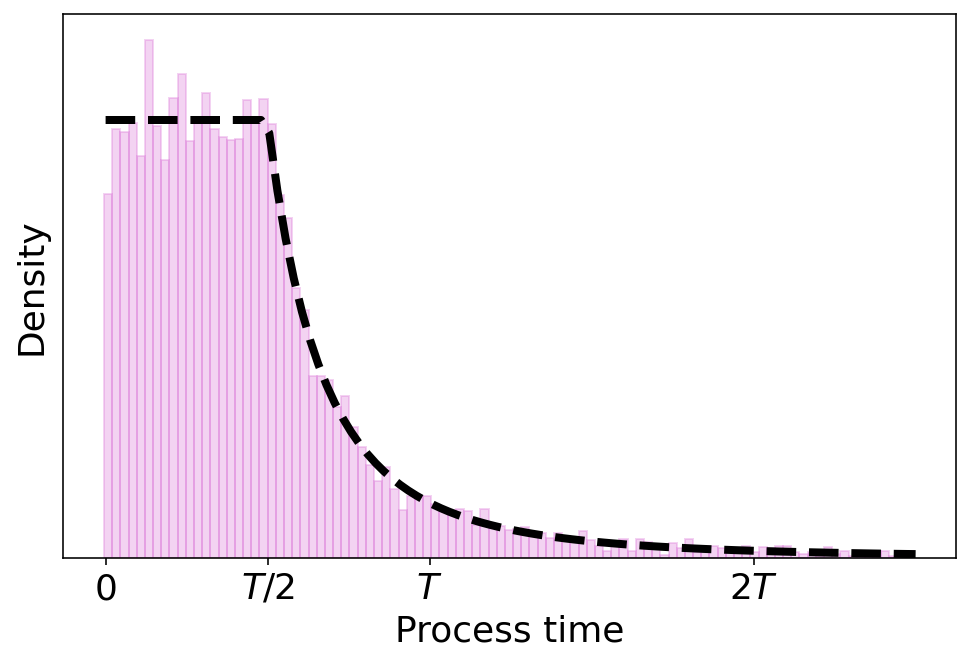

In [45]:
fig1,ax1 = plt.subplots(1,1,figsize=dims)

T = 2
t_ = np.linspace(0,5,100)
restime_lfr = np.zeros_like(t_)
restime_lfr[t_<= T/2] = 4/3/T
restime_lfr[t_> T/2] = T**2/(t_[t_> T/2])**3/6
ax1.plot(t_,restime_lfr,'k--',linewidth=lw)

restime_sim = T/(2*np.sqrt(1-(scipy.stats.uniform().rvs(nsim)))) * scipy.stats.uniform().rvs(nsim)
bins = t_-0.01

_=ax1.hist(restime_sim,bins,density=True,facecolor=model_colors[2],alpha=0.3,edgecolor=model_colors[2])
ax1.set_xlabel('Process time',fontsize=fs)
ax1.set_ylabel('Density',fontsize=fs)
ax1.set_yticks([])
ax1.set_xticks([0,T/2,T,2*T],['0',r'$T/2$',r'$T$',r'$2T$'],fontsize=fs)

plt.savefig('figs/lfr_iad.png',dpi=450)
plt.savefig('figs/lfr_iad.pdf')


# RNA simulation

## Sample trial

In [46]:
n_trials = 1
# n_cores = 10
max_state_space_size = 26
T = 5
norm_std = np.asarray([0]*6)
kinit=0.8
beta = 1.2
gamma = 3.14
burst_size_values = [2,5,1]
norm_mean = np.log10(burst_size_values + [kinit,beta,gamma])
switch_times = [0,1,3]
n_cells = 200

In [24]:
# res = parallelized_trial(n_cells,norm_std,norm_mean,T,switch_times,max_state_space_size,seed=2813308004,return_data=True)


In [ ]:
# res = (fit_result,X,samples,initcond,
#     t_true_sim,(t_uni,switch_times_uni),(t_exp,switch_times_exp),(t_lfr,switch_times_lfr)) 

first dimension of x is cells! second is time points! don't forget this!

In [ ]:
# import pickle
# with open('./data/gg230126_reactors_1gene1cond.pickle', "wb") as logLfs:
#     pickle.dump(res, logLfs)

In [47]:
import pickle
with open('./data/gg230126_reactors_1gene1cond.pickle', "rb") as logLfs:
    res = pickle.load(logLfs)


In [48]:
(fit_result,X,samples,initcond,
    t_true_sim,(t_uni,switch_times_uni),(t_exp,switch_times_exp),(t_lfr,switch_times_lfr)) = res

In [49]:
t = t_true_sim
b_ = np.asarray([burst_size_time_dep_fun(t_,switch_times,burst_size_values) for t_ in t])

In [50]:
ct_colors = ['deepskyblue','gold','forestgreen']
fs = 18


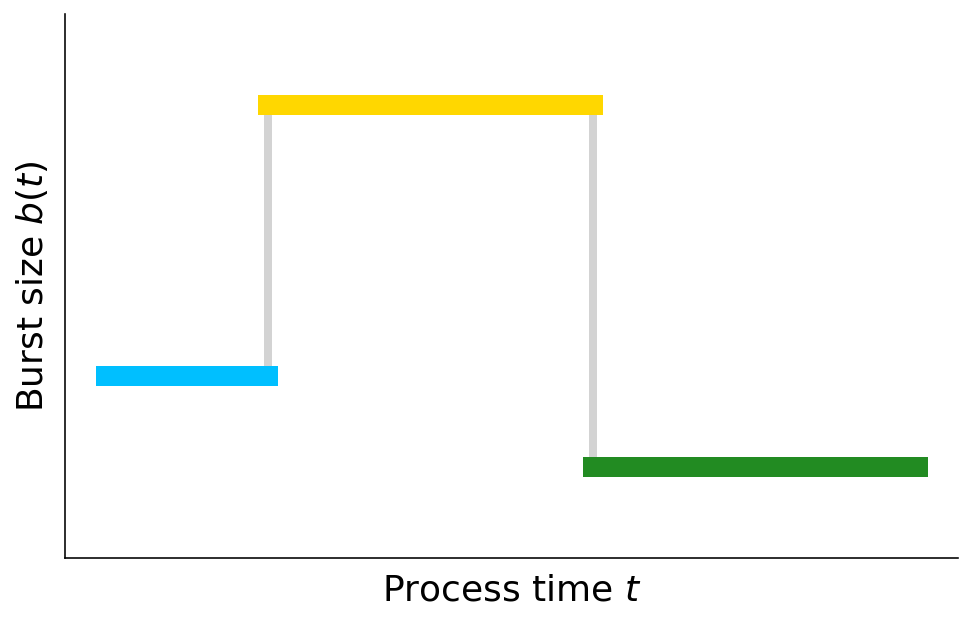

In [51]:
fig1,ax1 = plt.subplots(1,1,figsize=dims)
st = switch_times+[T]
for k in range(2):
    ax1.plot([st[k+1]]*2,[burst_size_values[k],burst_size_values[k+1]],color='lightgray',linewidth=4)
for k in range(3):
    ax1.plot([st[k],st[k+1]],[burst_size_values[k]]*2,linewidth=10,color=ct_colors[k])
ax1.set_ylabel(r'Burst size $b(t)$',fontsize=fs)
ax1.set_xlabel(r'Process time $t$',fontsize=fs)
ax1.set_ylim([0,6])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.savefig('figs/burstsize_cartoon.png',dpi=450)
plt.savefig('figs/burstsize_cartoon.pdf')


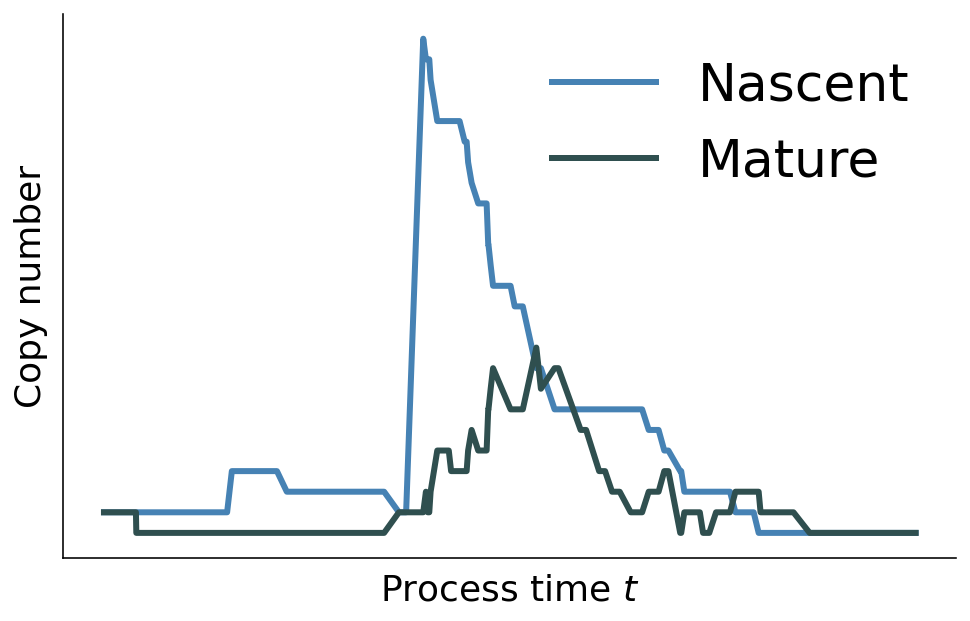

In [82]:
cellind = 39
fig1,ax1 = plt.subplots(1,1,figsize=dims)
ax1.plot(t_true_sim,X[cellind,:,0],label='Nascent',linewidth=3,color="steelblue")
ax1.plot(t_true_sim,X[cellind,:,1],label='Mature',linewidth=3,color="darkslategray")
# st = switch_times+[T]
# for k in range(2):
#     ax1.plot([st[k+1]]*2,[burst_size_values[k],burst_size_values[k+1]],color='lightgray',linewidth=4)
# for k in range(3):
#     ax1.plot([st[k],st[k+1]],[burst_size_values[k]]*2,linewidth=10,color=ct_colors[k])
ax1.set_ylabel(r'Copy number',fontsize=fs)
ax1.set_xlabel(r'Process time $t$',fontsize=fs)
# ax1.set_ylim([0,10])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(fontsize=26,frameon=False)

plt.savefig('figs/fig4a_copynumber_traj.png',dpi=450)
plt.savefig('figs/fig4a_copynumber_traj.pdf')


In [53]:
Y = X[np.arange(n_cells),np.arange(n_cells)]

In [54]:
Y.shape

(200, 2)

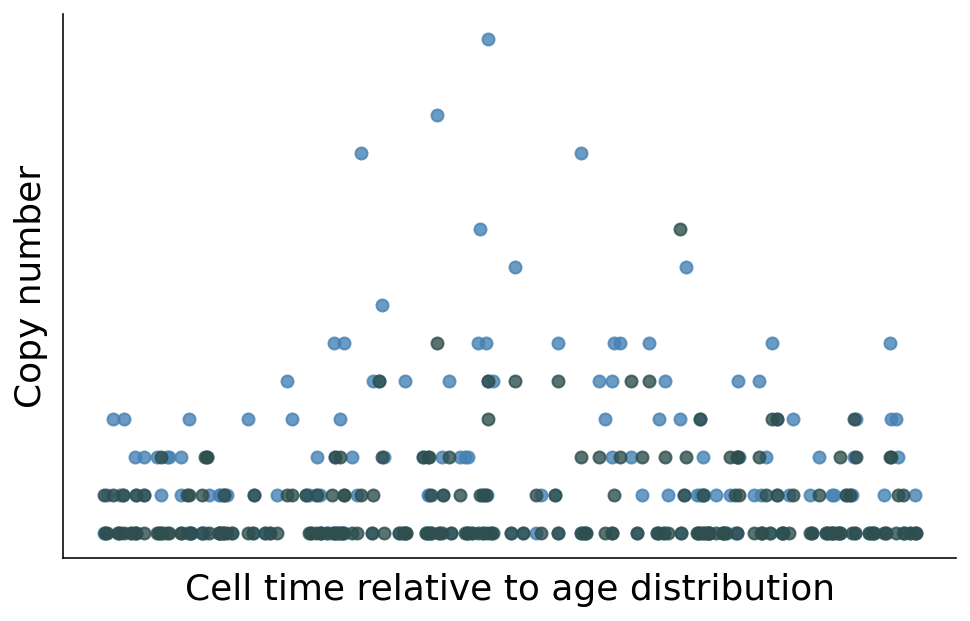

In [55]:
fig1,ax1 = plt.subplots(1,1,figsize=dims)

ax1.scatter(t_true_sim,Y[:,0],label='Nascent',color="steelblue",alpha=.8)
ax1.scatter(t_true_sim,Y[:,1],label='Mature',color="darkslategray",alpha=0.8)

# ax1.scatter(np.arange(n_cells),Y[:,0],label='Nascent',color="steelblue",alpha=.8)
# ax1.scatter(np.arange(n_cells),Y[:,1],label='Mature',color="darkslategray",alpha=0.8)
# st = switch_times+[T]
# for k in range(2):
#     ax1.plot([st[k+1]]*2,[burst_size_values[k],burst_size_values[k+1]],color='lightgray',linewidth=4)
# for k in range(3):
#     ax1.plot([st[k],st[k+1]],[burst_size_values[k]]*2,linewidth=10,color=ct_colors[k])
ax1.set_ylabel(r'Copy number',fontsize=fs)
ax1.set_xlabel(r'Cell time relative to age distribution',fontsize=fs)
# ax1.set_ylim([0,10])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# ax1.legend(fontsize=26,frameon=False)

plt.savefig('figs/counts_over_time.png',dpi=450)
plt.savefig('figs/counts_over_time.pdf')


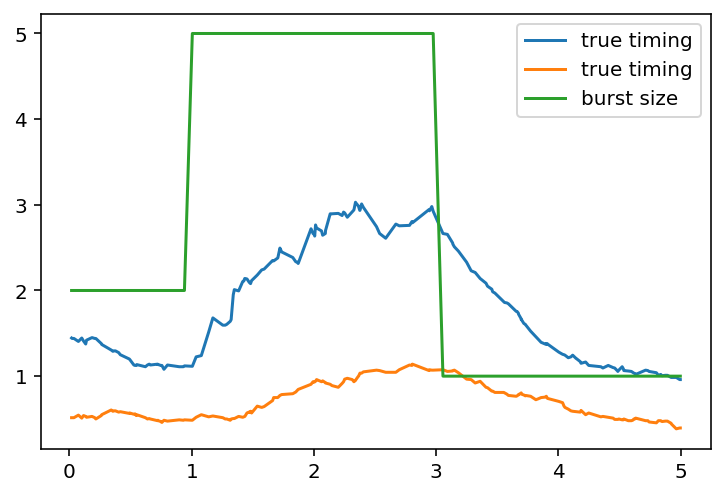

In [56]:
plt.plot(t_true_sim,X.mean(0),label='true timing')
# plt.plot(t_uni_quant,X.mean(0),label='evenly spaced')
plt.plot(t_true_sim,b_,label='burst size')
plt.legend()

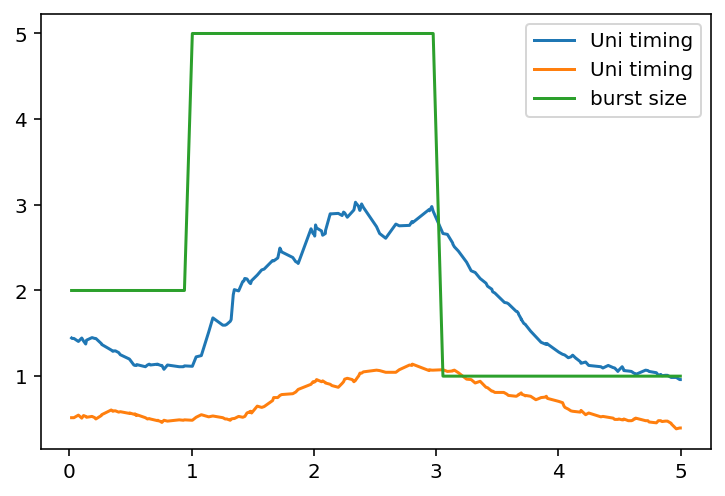

In [57]:
plt.plot(t_uni,X.mean(0),label='Uni timing')
# plt.plot(t_uni_quant,X.mean(0),label='evenly spaced')
plt.plot(t_uni,b_,label='burst size')
plt.legend()

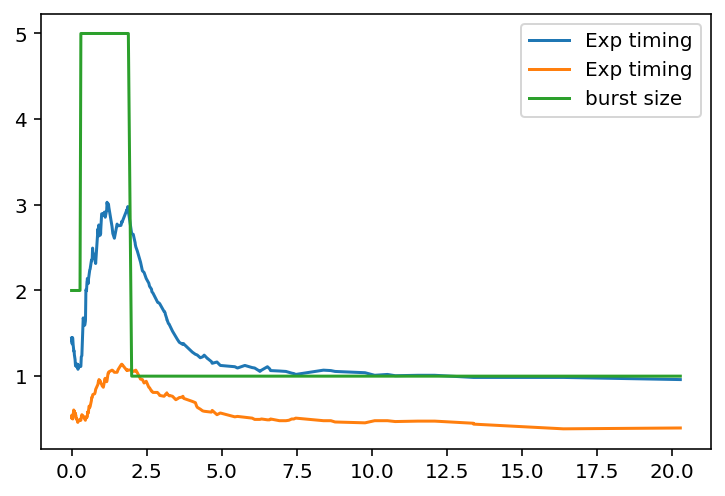

In [58]:
plt.plot(t_exp,X.mean(0),label='Exp timing')
# plt.plot(t_uni_quant,X.var(0),label='evenly spaced')
plt.plot(t_exp,b_,label='burst size')

plt.legend()

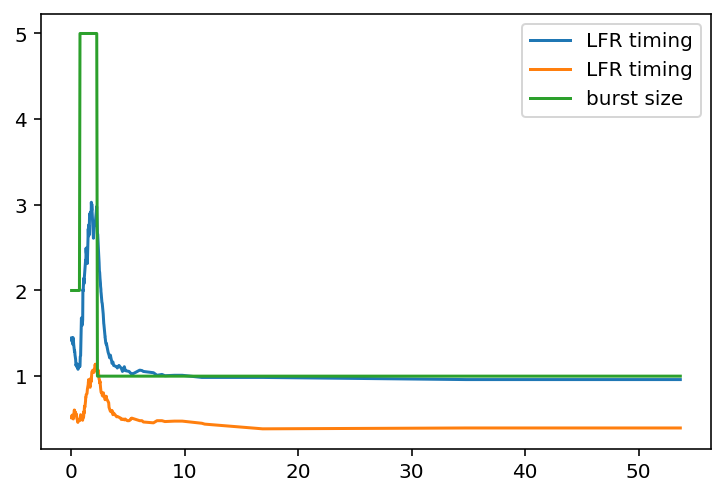

In [59]:
plt.plot(t_lfr,X.mean(0),label='LFR timing')
# plt.plot(t_uni_quant,X.var(0),label='evenly spaced')
plt.plot(t_lfr,b_,label='burst size')

plt.legend()

# Visualization 

Runetime: 0.44 seconds.


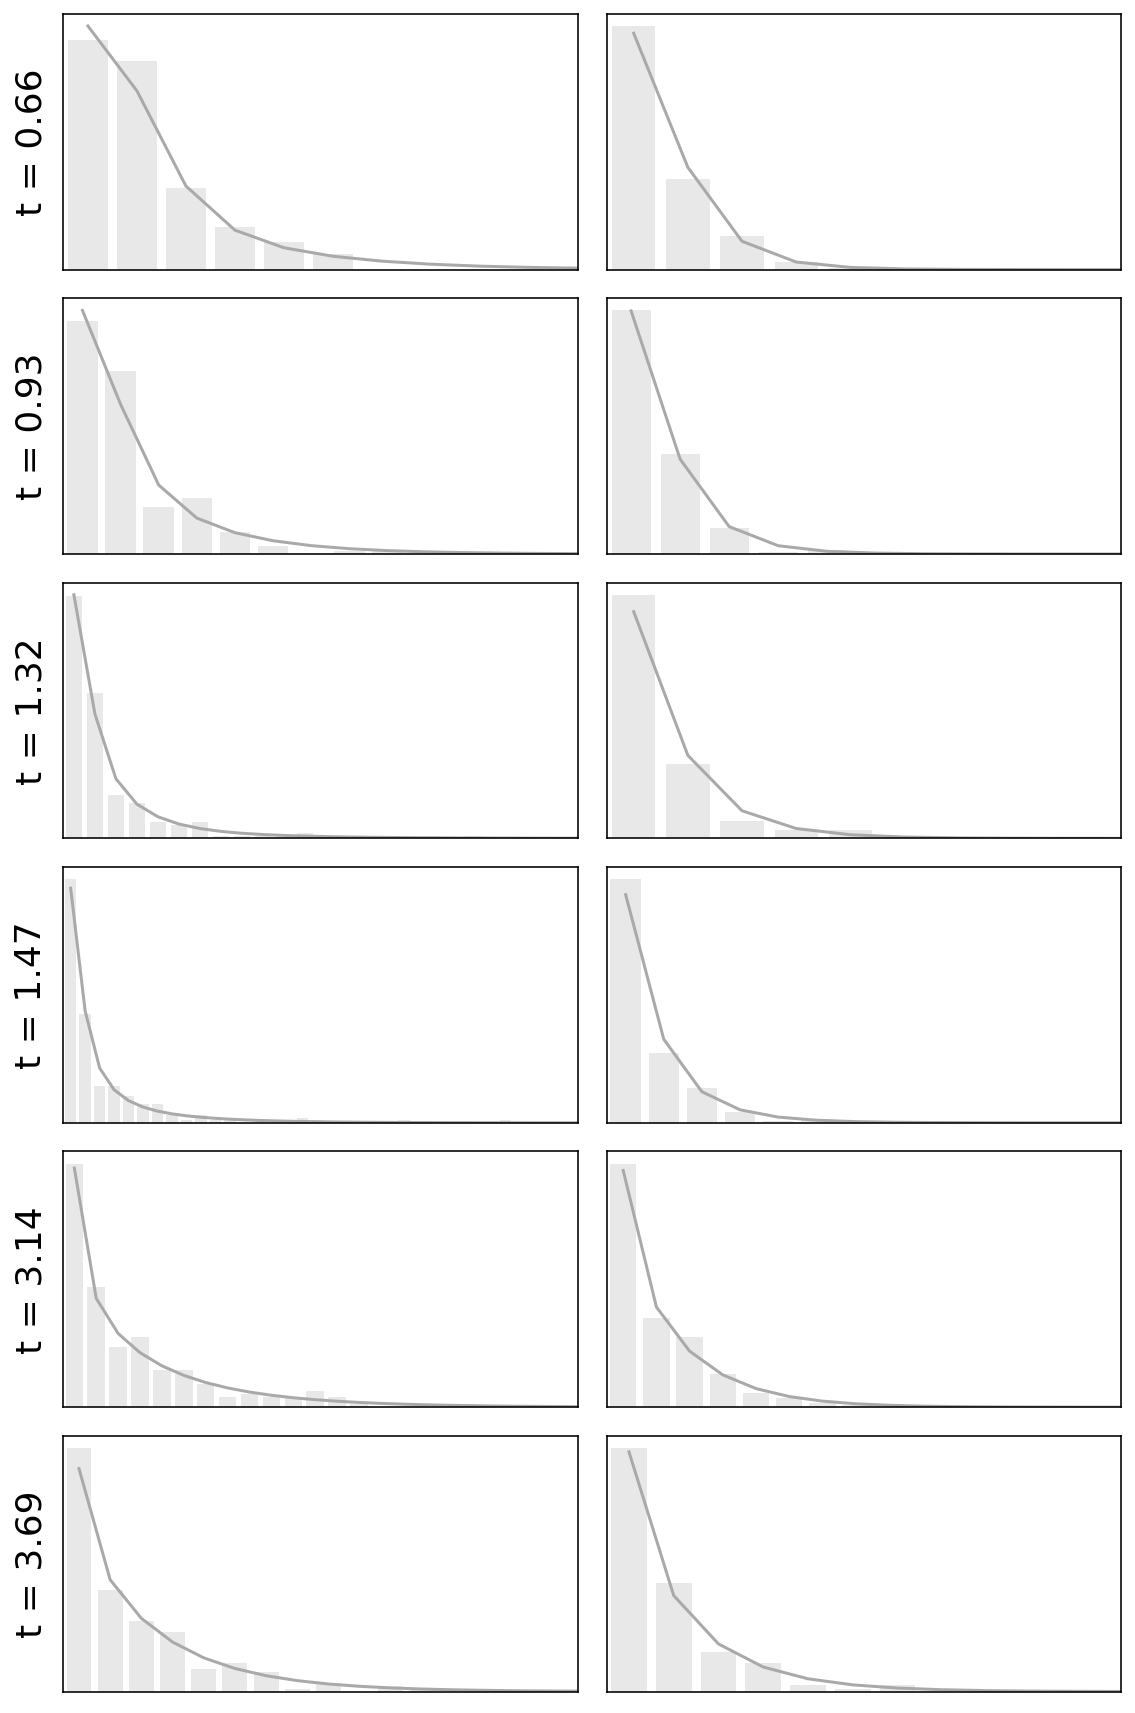

In [60]:

t_pts = [30,40,50,60,120,140]
nt=len(t_pts)
n=2
fig1,ax1=plt.subplots(nt,n,figsize=(8,12))

N=1
Pss_all = []
t1 = time.time()
#     mx = [64,32]
mx = [int(X[:,:,i].max()+10) for i in range(n)]
Pss_joint = pss_wrapper(kinit,beta,gamma,lambda t_: burst_size_time_dep_fun(t_,switch_times,burst_size_values),t_true_sim,mx,initcond[1:])[:,:,t_pts]
Pss_all=[Pss_joint.sum(1-i) for i in range(n)]
t2 = time.time()
print('Runetime: {:.2f} seconds.'.format(t2-t1))

for k,tind in enumerate(t_pts):
    t=t_true_sim[tind]

    ax1[k,0].set_ylabel('t = {:.2f}'.format(t),fontsize=fs)
    for i in range(n):
        mx = [1]*n

        ub = X[:,tind,i].max() + 2
        mx[i] = int(ub)
        Pss = Pss_all[i][:,k]

        bins = np.arange(X[:,tind,i].max()+6)-0.5
        hist,_ = np.histogram(X[:,tind,i],bins,density=True)
        ax1[k,i].bar(bins[:-1]+0.5,hist,color=uncond_colors[0],alpha=alf)

        ax1[k,i].plot(Pss,color=uncond_colors[1])


        ax1[k,i].set_xticks([])
        ax1[k,i].set_yticks([])
        ax1[k,i].set_xlim([-0.5,X[:,tind,i].max()+5])
#         ax1[k,i.se]
fig1.tight_layout()



In [61]:
fit_result[0]

array([2.  , 5.  , 1.  , 0.8 , 1.2 , 3.14])

In [62]:
fit_pars = 10**np.asarray([x.x for x in fit_result[1]])

In [63]:
fit_pars

array([[0.96705774, 3.37104247, 0.13582645, 0.84850312, 0.84014159,
        1.99295007],
       [1.42818087, 3.5720534 , 1.082354  , 2.46526968, 3.36084107,
        7.86118645],
       [0.96669015, 3.36908839, 0.1263902 , 1.13225178, 1.12001538,
        2.66039524]])

Runetime: 0.54 seconds.
Runetime: 1.02 seconds.
Runetime: 1.50 seconds.


TypeError: __init__() got an unexpected keyword argument 'location'

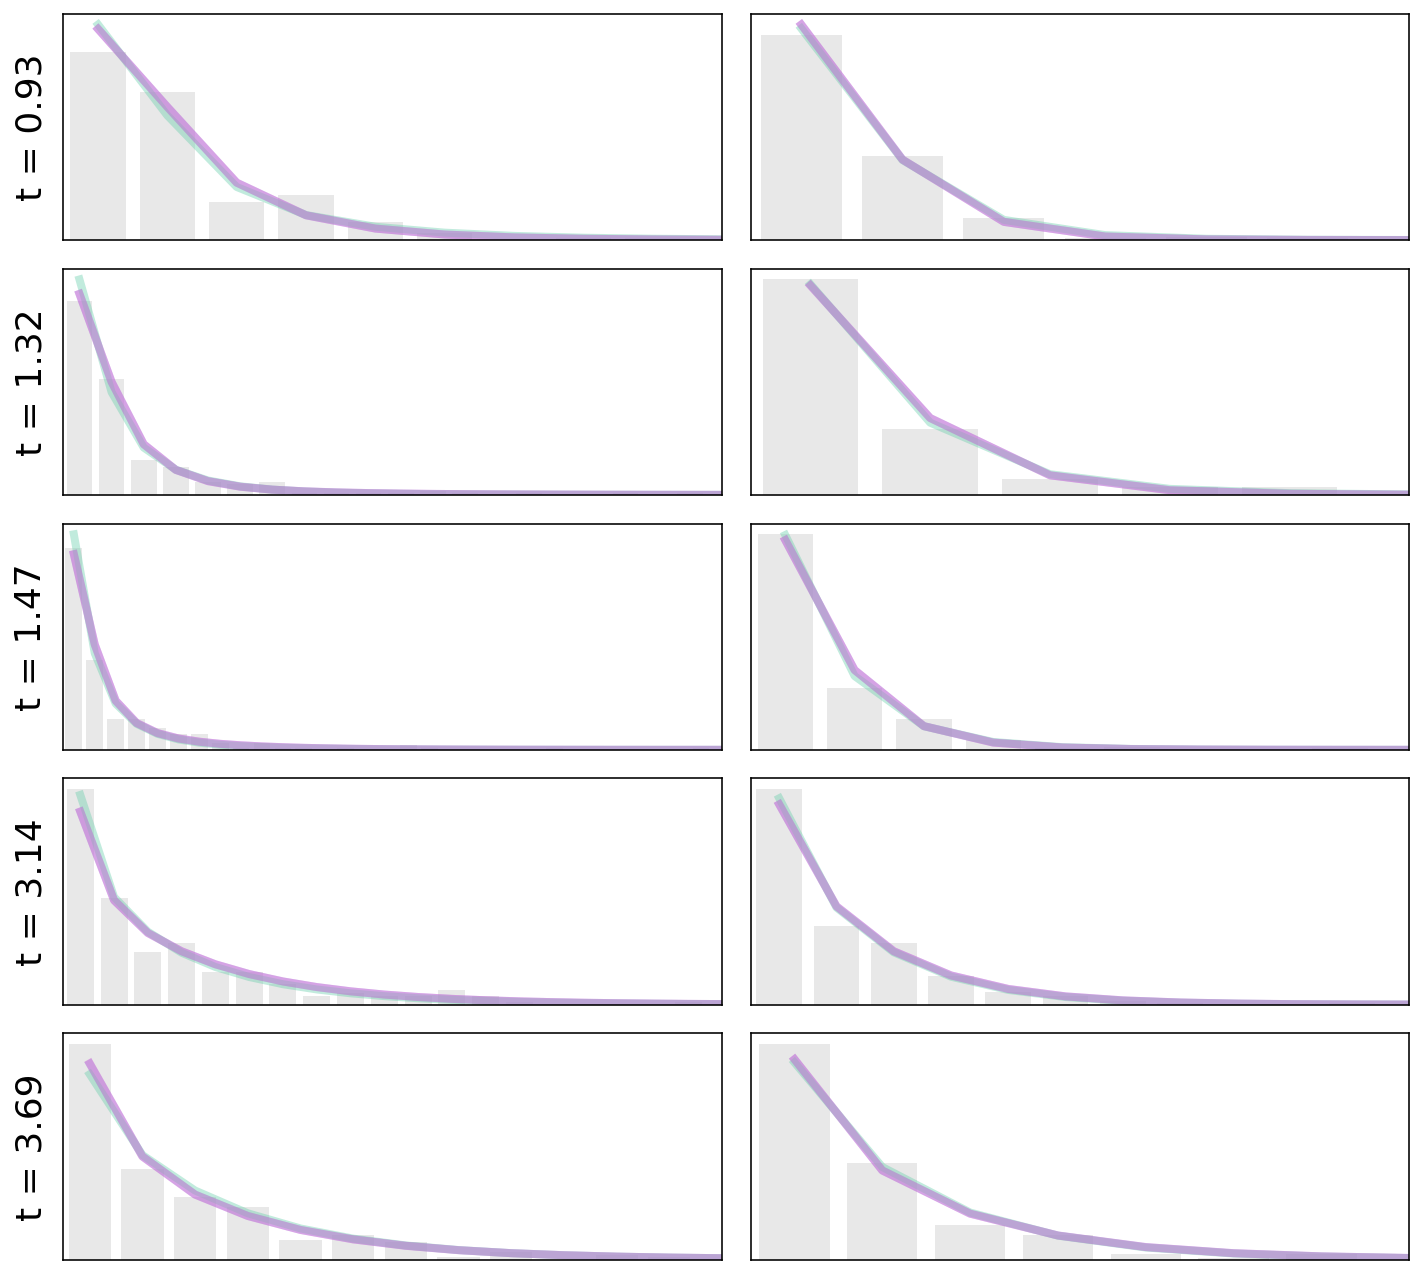

In [84]:
t_pts = [40,50,60,120,140]
nt=len(t_pts)
n=2
fig1,ax1=plt.subplots(nt,n,figsize=(10,9))

N=1
Pss_all = []
t1 = time.time()
#     mx = [64,32]
mx = [int(X[:,:,i].max()+10) for i in range(n)]

for k,tind in enumerate(t_pts):
    t=t_true_sim[tind]

    ax1[k,0].set_ylabel('t = {:.2f}'.format(t),fontsize=fs)
    for i in range(n):
        mx = [1]*n

        ub = X[:,tind,i].max() + 2
#         mx[i] = int(ub)
#         Pss = Pss_all[i][:,k]

        bins = np.arange(X[:,tind,i].max()+6)-0.5
        hist,_ = np.histogram(X[:,tind,i],bins,density=True)
        ax1[k,i].bar(bins[:-1]+0.5,hist,color=uncond_colors[0],alpha=alf,label='PFR sim.')


        ax1[k,i].set_xticks([])
        ax1[k,i].set_yticks([])

model_times = (t_uni,t_exp,t_lfr)
model_switches = (switch_times_uni,switch_times_exp,switch_times_lfr)


for model_ in range(3):
    mx = [int(X[:,:,i].max()+10) for i in range(n)]

    burst_size_values_fit = fit_pars[model_][:3]
    kinit_fit,beta_fit,gamma_fit = fit_pars[model_][3:]
    muN0_fit = burst_size_values_fit[0]*kinit_fit/beta_fit
    muM0_fit = burst_size_values_fit[0]*kinit_fit/gamma_fit

    initcond_fit = [['poisson',muN0_fit],
                ['poisson',muM0_fit]]

    Pss_joint = pss_wrapper(kinit_fit,beta_fit,gamma_fit,lambda t_: burst_size_time_dep_fun(t_,
                                                                                model_switches[model_],burst_size_values_fit),
                            model_times[model_],mx,initcond_fit)[:,:,t_pts]
    Pss_all=[Pss_joint.sum(1-i) for i in range(n)]
    t2 = time.time()
#     print(Pss_all)
    print('Runetime: {:.2f} seconds.'.format(t2-t1))

    for k,tind in enumerate(t_pts):
        for i in range(n):
            mx = [1]*n

            ub = X[:,tind,i].max() + 2
            mx[i] = int(ub)
            Pss = Pss_all[i][:,k]
            ax1[k,i].plot(Pss,color=model_colors[model_],linewidth=4,alpha=0.4,label=model_names[model_])
            ax1[k,i].set_xlim([-0.5,X[:,tind,i].max()+1])
    fig1.tight_layout()
ax1[0,1].legend(fontsize=fs,frameon=False,location='bottom right')
ax1[0,0].set_title('Nascent',fontsize=20)
ax1[0,1].set_title('Mature',fontsize=20)
ax1[len(t_pts)-1,0].set_xlabel('Copy number',fontsize=fs)
ax1[len(t_pts)-1,1].set_xlabel('Copy number',fontsize=fs)

plt.tight_layout()
plt.savefig('figs/fit_transient_distributions.png',dpi=450)
plt.savefig('figs/fit_transient_distributions.pdf')


## Cell number dependence

In [65]:
n_trials = 50
n_cores = 50
max_state_space_size = 30
T = 5
norm_std = np.asarray([0]*6)
k=0.8
beta = 1.2
gamma = 3.14
burst_size_values = [2,5,1]
norm_mean = np.log10(burst_size_values+[k,beta,gamma])
switch_times = [0,1,3]
n_cells_vec = [20,40,60,80,100,150,200]

In [66]:

# res = []
# for n_cells in n_cells_vec:
#     parfun = lambda seed: parallelized_trial(n_cells,norm_std,norm_mean,T,switch_times,max_state_space_size,seed)
#     res_nc = parallelize(
#         parfun,
#         np.arange(n_trials),
#         n_cores,
#         n_trials,
#         use_tqdm=True)
#     res.append(res_nc)

In [67]:
# import pickle
# with open('./data/gg230126_reactors_1gene.pickle', "wb") as logLfs:
#     pickle.dump(res, logLfs)


In [68]:
import pickle
with open('./data/gg230126_reactors_1gene.pickle', "rb") as logLfs:
    res = pickle.load(logLfs)


In [69]:
logL = -np.asarray([[[y.fun for y in x[1]] for x in r] for r in res])
pars = np.asarray([np.log10([x[0] for x in res[0]]) for r in res])

In [70]:
logL.shape

(7, 50, 3)

In [71]:
pars.shape

(7, 50, 6)

In [72]:
AIC_values = -2*logL 
AICmin = np.amin(AIC_values,2)
dAIC = AIC_values-AICmin[:,:,None]
AIC = np.exp(-dAIC/2)
AIC /= AIC.sum(2)[:,:,None]

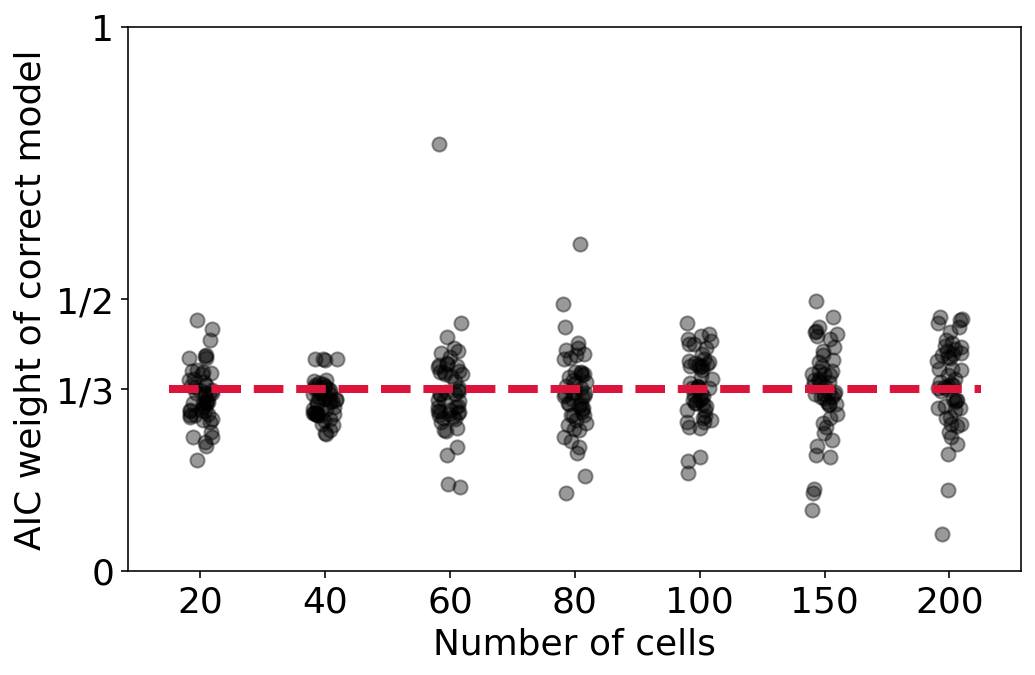

In [75]:
fig1,ax1 = plt.subplots(1,1,figsize=dims)
# nC = [20,50,100]
for k in range(len(n_cells_vec)):
    plt.scatter(k+(np.random.rand(n_trials)-0.5)/5, AIC[k,:,0],50,'k',alpha=0.4)
ax1.set_xticks(np.arange(len(n_cells_vec)),n_cells_vec,fontsize=fs)
ax1.set_xlabel('Number of cells',fontsize=fs)
ax1.set_ylabel('AIC weight of correct model',fontsize=fs)
plt.plot([-0.25,len(n_cells_vec)-0.75],[1/3]*2,'--',color='crimson',linewidth=4)
ax1.set_yticks([0,1/3,1/2,1],('0','1/3','1/2','1'),fontsize=fs)

plt.ylim([0,1])
# plt.legend()
plt.savefig('figs/aicw_cell_dep.png',dpi=450)
plt.savefig('figs/aicw_cell_dep.pdf')


# Parameter value dependence

In [76]:
n_trials = 200
n_cells = 200
n_cores = 60
max_state_space_size = 25
T = 5
norm_std = np.asarray([1]*6)
norm_mean = np.asarray([0.8,0.8,0.8,0,0,0])
switch_times = [0,1,3]
parfun = lambda seed: parallelized_trial(n_cells,norm_std,norm_mean,T,switch_times,max_state_space_size,seed)

This part occasionally breaks -- either `tqdm` fails or `multiprocess` does.

In [203]:
# res = parallelize(
#     parfun,
#     np.arange(n_trials),
#     n_cores,
#     n_trials,
#     use_tqdm=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [2:14:27<00:00, 40.34s/it]

Parallelization complete.


In [204]:
# import pickle
# with open('./data/gg230126_reactors_randomgene2.pickle', "wb") as logLfs:
#     pickle.dump(res, logLfs)


In [77]:
import pickle
with open('./data/gg230126_reactors_randomgene2.pickle', "rb") as logLfs:
    res = pickle.load(logLfs)

Note that the `res` structure (an `OptimizeResult` object) contains the true parameters as well as the fit results, so we can, in principle, compare them if desired.

In [78]:
pars = np.asarray(np.log10([x[0] for x in res]))

In [79]:
logL = -np.asarray([[y.fun for y in x[1]] for x in res])
AIC_values = -2*logL 
AICmin = np.amin(AIC_values,1)
dAIC = AIC_values-AICmin[:,None]
AIC = np.exp(-dAIC/2)
AIC /= AIC.sum(1)[:,None]

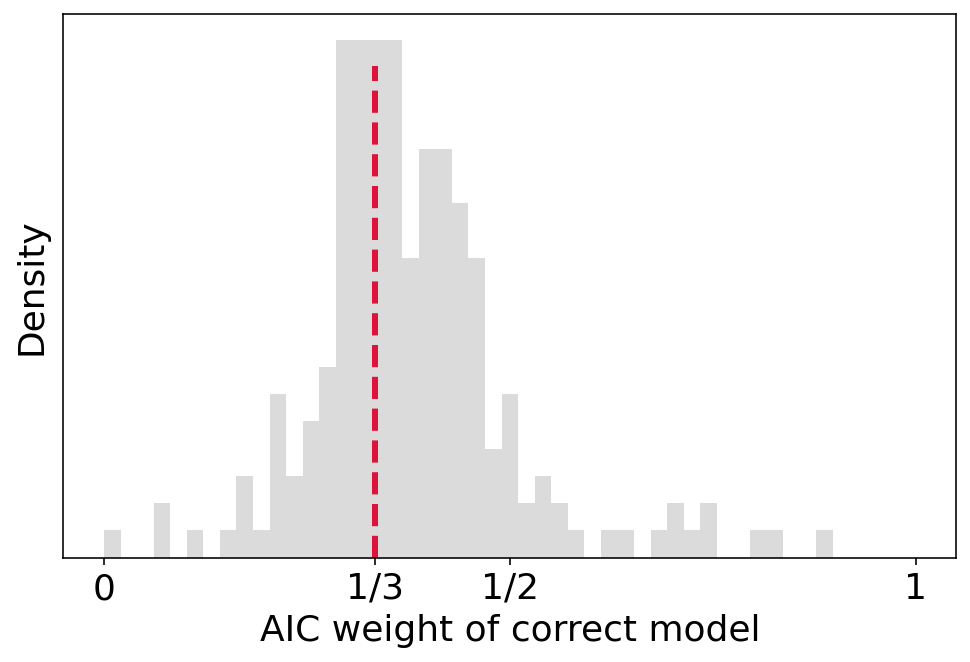

In [81]:
fig1,ax1 = plt.subplots(1,1,figsize=dims)
bins = np.linspace(0,1,50)
_=plt.hist(AIC[:,0],bins,density=True,color='lightgray',alpha=0.8)
ax1.plot([1/3]*2,[0,_[0].max()*0.95],'--',color='crimson',linewidth=3)

ax1.set_xticks([0,1/3,1/2,1],('0','1/3','1/2','1'),fontsize=fs)
ax1.set_xlabel('AIC weight of correct model',fontsize=fs)
ax1.set_ylabel('Density',fontsize=fs)
_=ax1.set_yticks([])

plt.savefig('figs/aicw_distrib.png',dpi=450)
plt.savefig('figs/aicw_distrib.pdf')


In [236]:
(AIC[:,0]/AIC[:,1]).shape

(200,)

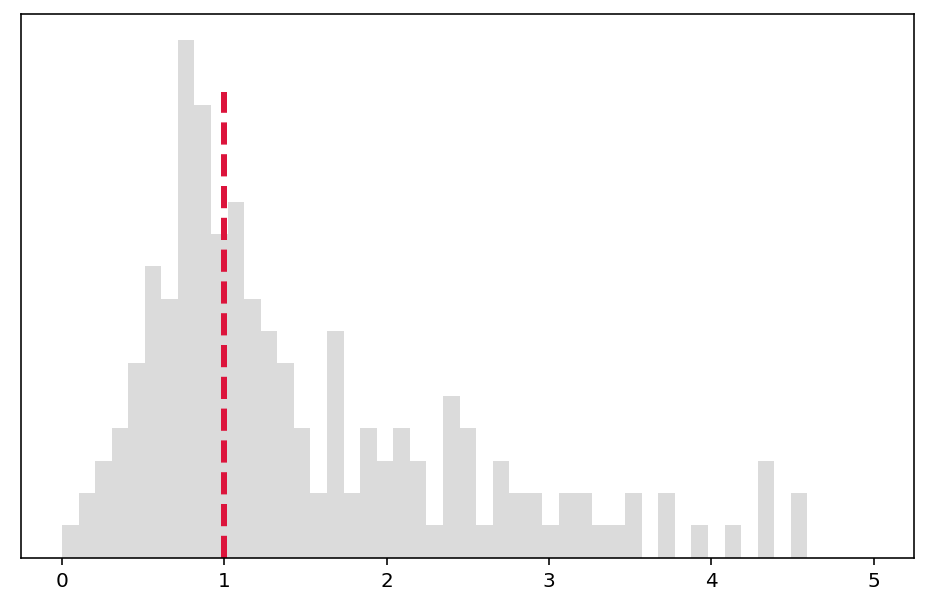

In [242]:
fig1,ax1 = plt.subplots(1,1,figsize=dims)
bins = np.linspace(0,5,50)
_=plt.hist(AIC[:,0]/AIC[:,1],bins,density=True,color='lightgray',alpha=0.8)
ax1.plot([1]*2,[0,_[0].max()*0.9],'--',color='crimson',linewidth=3)

# ax1.set_xticks([0,1/3,1/2,1],('0','1/3','1/2','1'),fontsize=fs)
# ax1.set_xlabel('AIC weight of correct model',fontsize=fs)
# ax1.set_ylabel('Density',fontsize=fs)
_=ax1.set_yticks([])

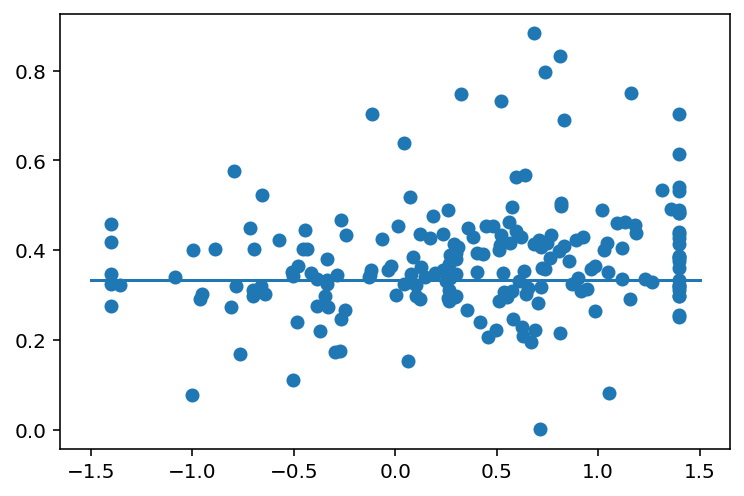

In [243]:
plt.scatter(pars[:,0],AIC[:,0])
plt.plot([-1.5,1.5],[1/3]*2)

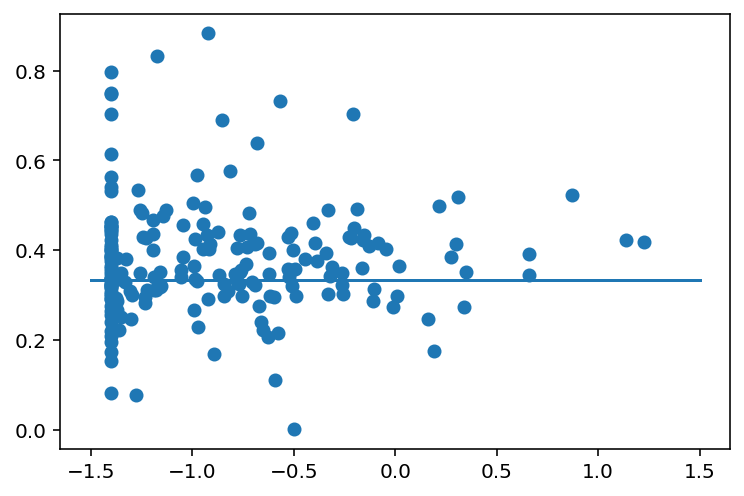

In [244]:
plt.scatter(pars[:,3],AIC[:,0])
plt.plot([-1.5,1.5],[1/3]*2)

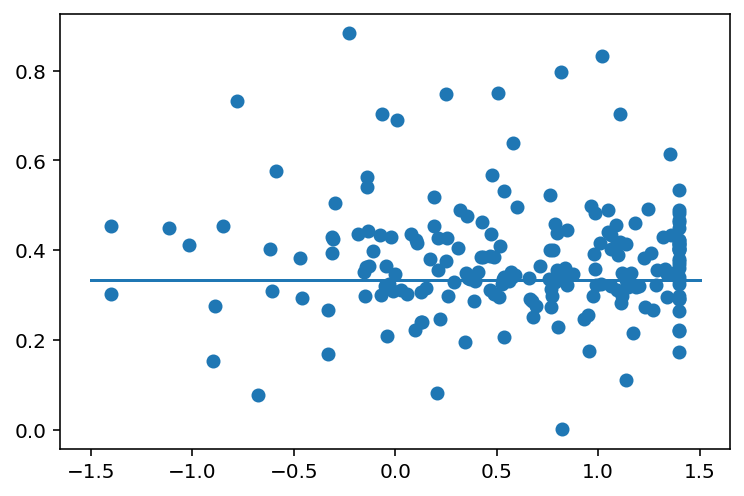

In [245]:
plt.scatter(pars[:,5],AIC[:,0])
plt.plot([-1.5,1.5],[1/3]*2)

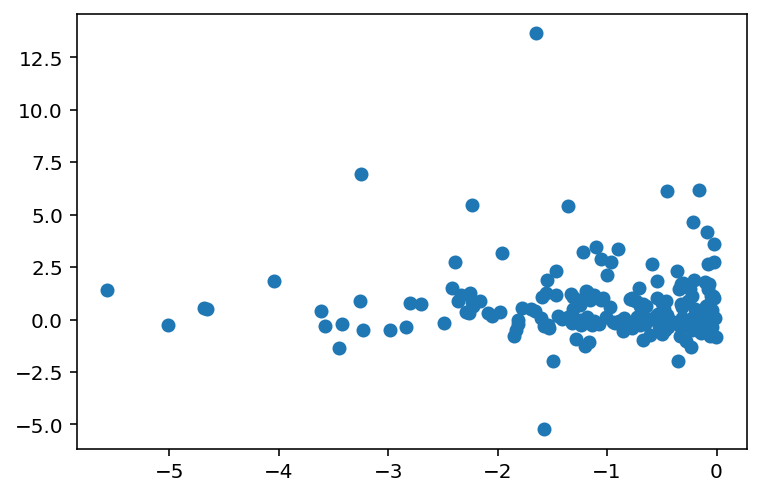

In [307]:
x = np.abs(rawpars[:,2]-rawpars[:,1]) + np.abs(rawpars[:,1]-rawpars[:,0])
x = np.log(rawpars[:,5] / (rawpars[:,3:].sum(1)))

plt.scatter(x,np.log(AIC[:,0]/AIC[:,1]))

In [299]:
# pars

In [246]:
rawpars = 10**pars

In [247]:
means = np.log10(rawpars[:,:3].max(1) * rawpars[:,3]*np.asarray([1/ rawpars[:,4],1/ rawpars[:,5]])).T

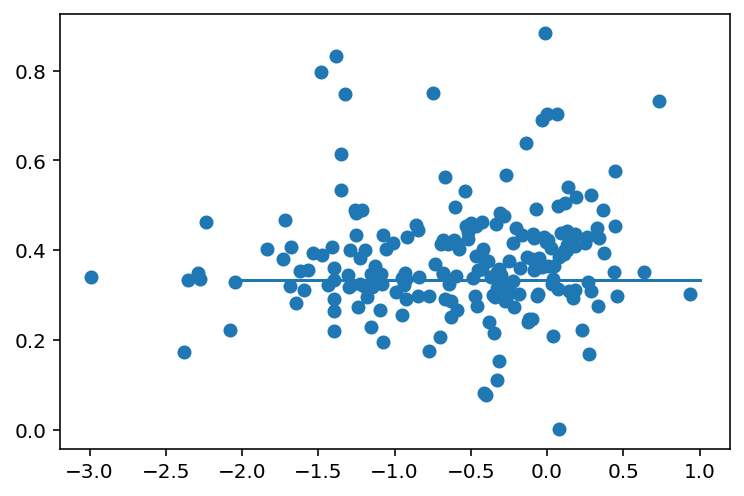

In [248]:
plt.scatter(means[:,1],AIC[:,0])
plt.plot([-2,1],[1/3]*2)

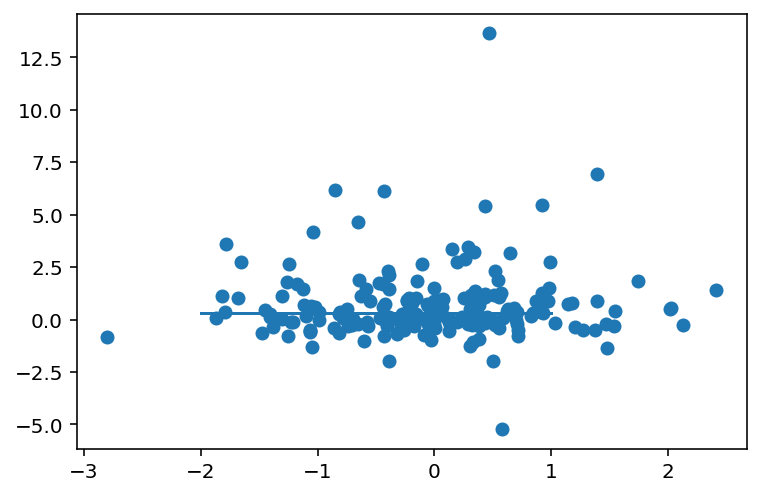

In [255]:
plt.scatter(means[:,1]-means[:,0],np.log(AIC[:,0]/AIC[:,1]))
plt.plot([-2,1],[1/3]*2)

In [256]:
# means

In [257]:
means.shape

(200, 2)

In [258]:
pars.shape

(200, 6)

In [259]:
regr = LinearRegression(fit_intercept=True)
# regr.fit(means, AIC[:,1])
regr.fit(pars, AIC[:,0])


LinearRegression()

In [260]:
# sklearn.metrics.r2_score(AIC[:,0],regr.predict(means))
sklearn.metrics.r2_score(AIC[:,0],regr.predict(pars))

0.09507775786676376

In [261]:
regr.coef_

array([ 0.04866695,  0.00121976, -0.0317537 ,  0.01772075, -0.01228492,
       -0.01318183])

In [262]:
regr.intercept_

0.40205856137682583

In [224]:
# from regressors import stats
